## 1. Load Dataset, Basic EDA

In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv('dataset_stroke.csv')

In [2]:
# ignore warnings

import warnings
warnings.filterwarnings('ignore')

### a. Quick Check

In [3]:
df.head(5)

,gender,age,hypertension,heart_disease,work_type,avg_glucose_level,bmi,stroke
0,1,80,0,0,0,75.620000,25.100000,0
1,0,64,0,0,2,113.680000,24.200000,0
2,0,73,1,0,2,71.290000,37.700000,0
3,0,71,0,1,2,218.092005,29.950318,1
4,1,51,0,0,2,92.950000,23.900000,0


In [4]:
df.describe()

,gender,age,hypertension,heart_disease,work_type,avg_glucose_level,bmi,stroke
count,5055.000000,5055.000000,5055.000000,5055.000000,5055.000000,5055.000000,5055.000000,5055.000000
mean,0.533729,47.731949,0.091592,0.054402,29.408902,111.276830,29.166742,0.229080
std,0.498910,23.111256,0.288478,0.226831,80.755149,50.209475,7.305279,0.420282
min,0.000000,0.000000,0.000000,0.000000,0.000000,55.220000,10.300000,0.000000
25%,0.000000,30.000000,0.000000,0.000000,0.000000,77.515000,24.400000,0.000000
50%,1.000000,51.000000,0.000000,0.000000,0.000000,93.411304,28.600000,0.000000
75%,1.000000,67.000000,0.000000,0.000000,1.000000,121.180000,32.796912,0.000000
max,1.000000,82.000000,1.000000,1.000000,255.000000,271.740000,97.600000,1.000000


##### There's no need to treat null values because there is none, as shown below

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5055 entries, 0 to 5054
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5055 non-null   int64  
 1   age                5055 non-null   int64  
 2   hypertension       5055 non-null   int64  
 3   heart_disease      5055 non-null   int64  
 4   work_type          5055 non-null   int64  
 5   avg_glucose_level  5055 non-null   float64
 6   bmi                5055 non-null   float64
 7   stroke             5055 non-null   int64  
dtypes: float64(2), int64(6)
memory usage: 316.1 KB


##### Might need to put some categories as 'other'

In [6]:
df.work_type.value_counts()

work_type
0      3048
1       886
255     553
2       543
254      18
214       1
152       1
66        1
70        1
122       1
230       1
249       1
Name: count, dtype: int64

### b. EDA

#### Glucose Level

##### Glucose Level is Bimodal, roughly divided into two groups with the division around 170 units

<Axes: >

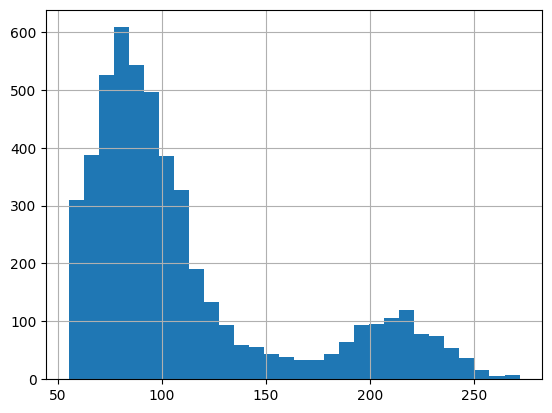

In [7]:
df.avg_glucose_level.hist(bins=30)

##### When split between stroke and non-stroke people, we can see that it's still a bimodal, but the ratio of stroke people with high blood sugar is higher

<Axes: >

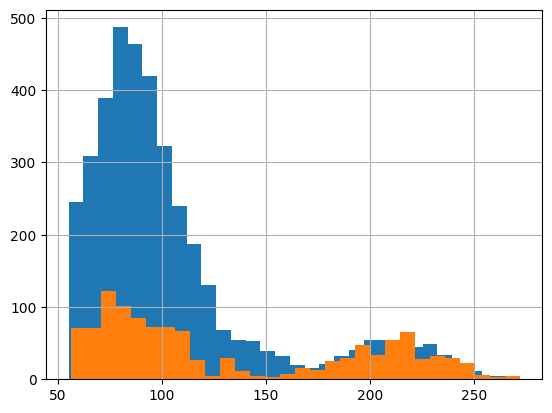

In [8]:
df[df.stroke==0].avg_glucose_level.hist(bins=30)
df[df.stroke==1].avg_glucose_level.hist(bins=30)

#### Age
##### Age level is uniformly distributed, but there are more people in the older range

<Axes: >

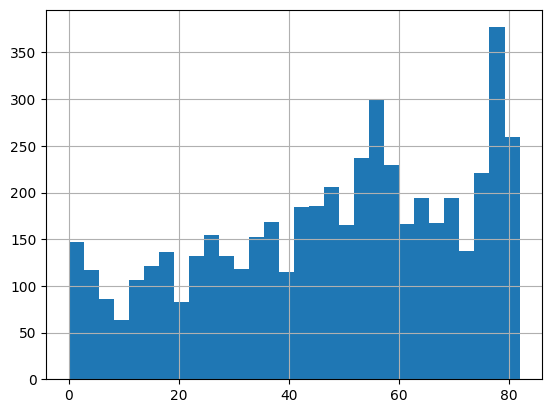

In [9]:
df.age.hist(bins=30)

##### Clearly people with older age tend to have more strokes

<Axes: >

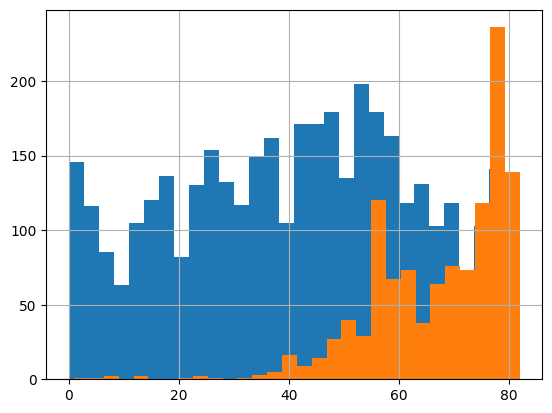

In [10]:
df[df.stroke==0].age.hist(bins=30)
df[df.stroke==1].age.hist(bins=30)

#### BMI
##### BMI is normally distributed, a little skewed right

<Axes: >

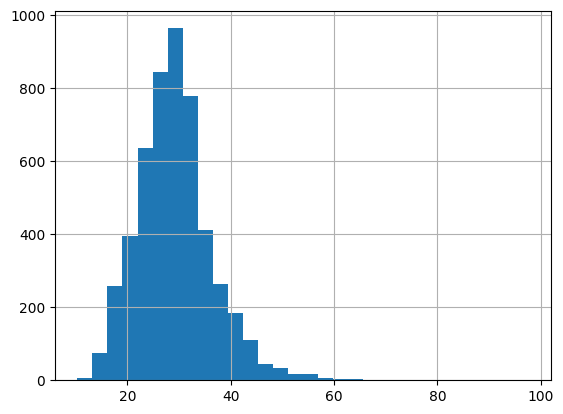

In [11]:
df.bmi.hist(bins=30)

##### There is no clear relationship between BMI and probability of stroke

<Axes: >

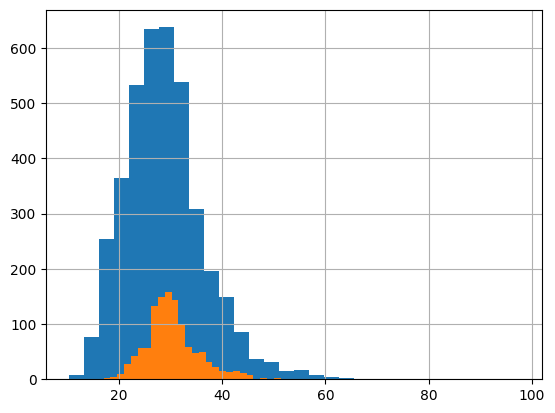

In [12]:
df[df.stroke==0].bmi.hist(bins=30)
df[df.stroke==1].bmi.hist(bins=30)

### c. Assess Imbalance

<Axes: title={'center': 'Distribution of Stroke Patients in the Dataset'}>

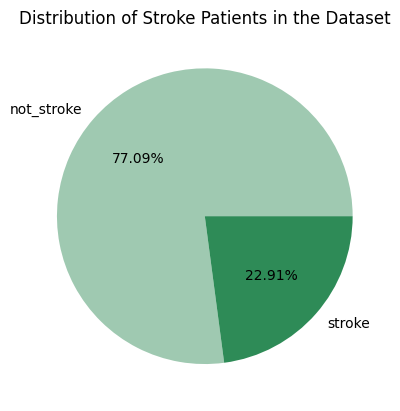

In [13]:
import seaborn as sns
seagreen_palette = sns.light_palette('seagreen')
df.stroke.replace({0: 'not_stroke', 1: 'stroke'}).value_counts().plot.pie(
    label="",
    title="Distribution of Stroke Patients in the Dataset",
    autopct="%.2f%%",
    colors = seagreen_palette[2::3]
)

## 2. Data Preprocessing, Data Cleaning, Feature Engineering

### a. Re-categorize work_type

In [14]:
top_5_cat = df.work_type.value_counts().nlargest(5).index

df['work_type'] = df.work_type.where(df.work_type.isin(top_5_cat), other='other')

In [15]:
df['work_type'] = df.work_type.astype('str').astype('category')

### b. Age-Binning


##### According to [CDC.gov](https://www.cdc.gov/stroke/risk_factors.htm#:~:text=The%20chance%20of%20having%20a,65%20years%20also%20have%20strokes.&text=In%20fact%2C%20about%20one%20in,adults%20ages%2015%20to%2049), risk of stroke doubles every ten year after age of 55, so we can bin it accordingly. 

In [16]:
bins = [0, 45, 55, 65, 75, np.inf]

df['age_range'] = pd.cut(df['age'], bins, labels=False)
df['age_range'] = df['age_range'].fillna(0).astype(int)

In [17]:
df.groupby('age_range')['bmi'].count()


age_range
0    2149
1     744
2     807
3     635
4     720
Name: bmi, dtype: int64

### c. Find correlations

<Axes: >

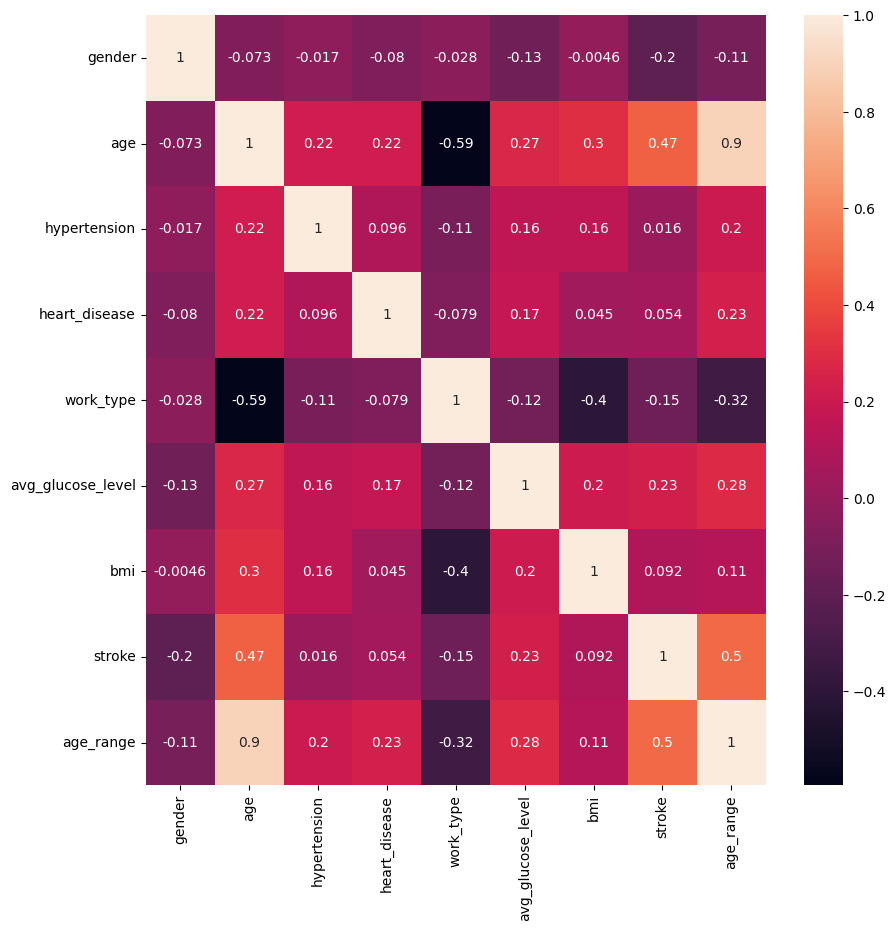

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

seagreen_palette = sns.light_palette('seagreen')

fig, ax = plt.subplots(figsize=(10,10))       
sns.heatmap(df.replace('other', 1000).corr(), annot=True, ax=ax)

## 3. Model Selection

### a. XGBoost

##### Choose features and split data into train, val and test

In [19]:
FEATURES = ['gender', 'age_range', 'hypertension', 'heart_disease', 'work_type',
       'avg_glucose_level', 'bmi']

LABELS = ['stroke']

In [20]:
from sklearn.model_selection import train_test_split

#create feature set and labels
X = df[FEATURES]
y = df[LABELS]

#train and test split
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.20, random_state=68, stratify=y)

In [21]:
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.20, random_state=68, stratify=y_trainval)

#### Hyperparam tuning

##### We first optimize by finding the model with max ROC AUC

In [22]:
from hyperopt import fmin, tpe, hp, SparkTrials, STATUS_OK, Trials
from hyperopt.pyll import scope
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

import xgboost as xgb
import mlflow
import time
mlflow.set_tracking_uri("http://localhost:5000")

experiment_name = "Hyperparam Search XGBoost - Stroke Detection"
run_name = "inital_search_for_params"

mlflow.set_experiment(experiment_name)

experiment = mlflow.get_experiment_by_name(experiment_name)
experiment_id = experiment.experiment_id

dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dval_reg = xgb.DMatrix(X_val, y_val, enable_categorical=True)

search_space = {
    'learning_rate': hp.loguniform('learning_rate', 0, 0.01),
    'max_depth': scope.int(hp.uniform('max_depth', 1, 100)),
    'min_child_weight': hp.loguniform('min_child_weight', -2, 3),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'gamma': hp.loguniform('gamma', -10, 10),
    'alpha': hp.loguniform('alpha', -10, 10),
    'lambda': hp.loguniform('lambda', -10, 10),
    'scale_pos_weight': hp.uniform('scale_pos_weight', 10, 50),
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'seed': 123,
}

def train_model(params):

    # With MLflow autologging, hyperparameters and the trained model are automatically logged to MLflow.
    mlflow.xgboost.autolog(silent=True)

    # However, we can log additional information by using an MLFlow tracking context manager
    with mlflow.start_run(nested=True, run_name=run_name, experiment_id = experiment_id):

        # Train model and record run time
        start_time = time.time()
        booster = xgb.train(params=params, dtrain=dtrain_reg, num_boost_round=5000, evals=[(dval_reg, "validation")], early_stopping_rounds=50, verbose_eval=False)
        run_time = time.time() - start_time
        mlflow.log_metric('runtime', run_time)

        # Record AUC as primary loss for Hyperopt to minimize
        predictions_test = booster.predict(dval_reg)
        auc_score = roc_auc_score(y_val, predictions_test)

        # Set the loss to -1*auc_score so fmin maximizes the auc_score
        return {'status': STATUS_OK, 'loss': -auc_score, 'booster': booster.attributes()}

In [23]:
with mlflow.start_run(run_name=run_name, experiment_id = experiment_id):
  best_params = fmin(
    fn=train_model, 
    space=search_space, 
    algo=tpe.suggest, 
    max_evals=25,
    rstate=np.random.default_rng(123),
  )

100%|██████████| 25/25 [00:16<00:00,  1.54trial/s, best loss: -0.9180873180873181]


We can view the MLFlow training summary by running `mlflow ui` on our Terminal

In [24]:
best_params

{'alpha': 0.005584013947653967,
 'colsample_bytree': 0.767872589594243,
 'gamma': 0.011320203235405252,
 'lambda': 6.244709782669356,
 'learning_rate': 1.0052846269486904,
 'max_depth': 41.144268405673984,
 'min_child_weight': 4.7903550386199765,
 'scale_pos_weight': 39.37939616204363,
 'subsample': 0.9980654615049733}

In [25]:
fixed_params = {
    'enable_categorical': True,
    'tree_method': 'hist',
    'eval_metric': "auc",
    'early_stopping_rounds': 10
}

In [26]:
final_params = {**best_params, **fixed_params}
final_params['max_depth'] = int(final_params['max_depth'])

In [27]:
val_set = [( X_train, y_train), ( X_val, y_val)]
xgb_model = xgb.XGBClassifier(**final_params)
xgb_model.fit(X_train, y_train, eval_set=val_set)
y_pred = xgb_model.predict(X_test)

[0]	validation_0-auc:0.89298	validation_1-auc:0.86244
[1]	validation_0-auc:0.92999	validation_1-auc:0.88038
[2]	validation_0-auc:0.94895	validation_1-auc:0.88717
[3]	validation_0-auc:0.96584	validation_1-auc:0.89527
[4]	validation_0-auc:0.97184	validation_1-auc:0.90620
[5]	validation_0-auc:0.97851	validation_1-auc:0.91316
[6]	validation_0-auc:0.98306	validation_1-auc:0.91796
[7]	validation_0-auc:0.98553	validation_1-auc:0.91752
[8]	validation_0-auc:0.98780	validation_1-auc:0.91685
[9]	validation_0-auc:0.99106	validation_1-auc:0.92062
[10]	validation_0-auc:0.99310	validation_1-auc:0.92233
[11]	validation_0-auc:0.99449	validation_1-auc:0.92105
[12]	validation_0-auc:0.99607	validation_1-auc:0.92094
[13]	validation_0-auc:0.99652	validation_1-auc:0.92115
[14]	validation_0-auc:0.99724	validation_1-auc:0.92222
[15]	validation_0-auc:0.99746	validation_1-auc:0.92429
[16]	validation_0-auc:0.99769	validation_1-auc:0.92532
[17]	validation_0-auc:0.99785	validation_1-auc:0.92605
[18]	validation_0-au

In [28]:
(
    accuracy_score(y_test, y_pred),
    precision_score(y_test, y_pred),
    recall_score(y_test, y_pred),
    f1_score(y_test, y_pred),
    roc_auc_score(y_test, y_pred),
)

(0.8367952522255193,
 0.6,
 0.8663793103448276,
 0.708994708994709,
 0.8471819529901288)

##### However, since this is stroke detection, we might need to prioritize on Recall, hence we can shift the param search towards finding the best recall

We can try to increase the scale_pos_weight manually and it will increase the recall

In [29]:
best_params

{'alpha': 0.005584013947653967,
 'colsample_bytree': 0.767872589594243,
 'gamma': 0.011320203235405252,
 'lambda': 6.244709782669356,
 'learning_rate': 1.0052846269486904,
 'max_depth': 41.144268405673984,
 'min_child_weight': 4.7903550386199765,
 'scale_pos_weight': 39.37939616204363,
 'subsample': 0.9980654615049733}

### b. Neural Network

#### Preprocess for Neural Net

In [30]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from typing import Sequence

from sklearn import metrics
from sklearn import model_selection
from sklearn import preprocessing

In [31]:
CATEGORICAL_FEATURES = ['work_type', 'gender']
NUMERIC_FEATURES = ['age', 'avg_glucose_level', 'bmi', 'hypertension', 'heart_disease']
LABELS = ['stroke']

##### One hot encoding for all the categorical features

In [32]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
one_hot_encoder.fit(df[CATEGORICAL_FEATURES])

df_encoded = one_hot_encoder.transform(df[CATEGORICAL_FEATURES])

df_encoded = pd.DataFrame(data=df_encoded, columns=one_hot_encoder.get_feature_names_out())


In [33]:
df_dnn = df[NUMERIC_FEATURES].join(df_encoded).join(df[LABELS])
CATEGORICAL_FEATURES = one_hot_encoder.get_feature_names_out()

##### Min Max Scaler for Numeric Features

In [34]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(df[NUMERIC_FEATURES])
df_scaled = scaler.transform(df[NUMERIC_FEATURES])

In [35]:
df_scaled = pd.DataFrame(data=df_scaled, columns=scaler.get_feature_names_out())

In [36]:
df_dnn = df_dnn[CATEGORICAL_FEATURES].join(df_scaled).join(df[LABELS])

##### Split Data

In [37]:
def dnn_split(df):
  for key in CATEGORICAL_FEATURES:
    encoder = preprocessing.LabelEncoder()
    df[key] = encoder.fit_transform(df[key])

  df_traineval, df_test = model_selection.train_test_split(
      df, test_size=0.2, random_state=123)

  df_train, df_eval = model_selection.train_test_split(
      df_traineval, test_size=0.2, random_state=123)

  def feature_dict(df):
    features = {}
    for k, v in dict(df[CATEGORICAL_FEATURES]).items():
        features[k] = v.values
    for k, v in dict(df[NUMERIC_FEATURES]).items():
        features[k] = v.values
    return features

  x_train, y_train = feature_dict(df_train), df_train[LABELS].values
  x_eval, y_eval = feature_dict(df_eval), df_eval[LABELS].values
  x_test, y_test = feature_dict(df_test), df_test[LABELS].values

  return x_train, x_eval, y_train, y_eval, x_test, y_test


In [38]:
x_train, x_eval, y_train, y_eval, x_test, y_test = dnn_split(df_dnn)

#### Build Network

In [39]:
numeric_inputs = []

for col in df_dnn[NUMERIC_FEATURES].columns:
    numeric_inputs.append(tf.keras.layers.Input(shape=(1,), name=col))
    
categorical_inputs = []

for col in df_dnn[CATEGORICAL_FEATURES].columns:
    categorical_inputs.append(tf.keras.layers.Input(shape=(1,), name=col))

In [40]:
deep_input = tf.keras.layers.concatenate(numeric_inputs + categorical_inputs, name='all_features')
first_hidden_layer = tf.keras.layers.Dense(64, activation='relu', name='first_hidden')(deep_input)
second_hidden_layer = tf.keras.layers.Dense(8, activation='relu', name='second_hidden')(first_hidden_layer)
output_layer = tf.keras.layers.Dense(1, activation='sigmoid', name='sigmoid_output')(second_hidden_layer)
deep_model = tf.keras.Model(
    inputs=numeric_inputs+categorical_inputs,
    outputs=output_layer
)

In [41]:
deep_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 age (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 avg_glucose_level (InputLa  [(None, 1)]                  0         []                            
 yer)                                                                                             
                                                                                                  
 bmi (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 hypertension (InputLayer)   [(None, 1)]                  0         []                        

#### Train Model

In [42]:
loss = keras.losses.BinaryCrossentropy(from_logits=False)
metrics = keras.metrics.AUC(from_logits=False)
deep_model.compile(
    loss=loss,
    metrics=metrics,
    # metrics='accuracy',
    optimizer=keras.optimizers.Adam(lr=0.0001)
)

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', min_lr=1e-6),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),
]

class_weight = {0: 0.10,
                1: 0.90}

history = deep_model.fit(
    x=x_train,
    y=y_train,
    batch_size=1024,
    epochs=500,
    verbose=2,
    callbacks=callbacks,
    validation_data=(x_eval, y_eval),
    # class_weight=class_weight
).history

Epoch 1/500
4/4 - 0s - loss: 0.7374 - auc: 0.4584 - val_loss: 0.7125 - val_auc: 0.4087 - lr: 0.0010 - 457ms/epoch - 114ms/step
Epoch 2/500
4/4 - 0s - loss: 0.7031 - auc: 0.4288 - val_loss: 0.6812 - val_auc: 0.3764 - lr: 0.0010 - 27ms/epoch - 7ms/step
Epoch 3/500
4/4 - 0s - loss: 0.6741 - auc: 0.3894 - val_loss: 0.6545 - val_auc: 0.3660 - lr: 0.0010 - 24ms/epoch - 6ms/step
Epoch 4/500
4/4 - 0s - loss: 0.6502 - auc: 0.3590 - val_loss: 0.6320 - val_auc: 0.3941 - lr: 0.0010 - 26ms/epoch - 6ms/step
Epoch 5/500
4/4 - 0s - loss: 0.6305 - auc: 0.3836 - val_loss: 0.6149 - val_auc: 0.4321 - lr: 0.0010 - 25ms/epoch - 6ms/step
Epoch 6/500
4/4 - 0s - loss: 0.6149 - auc: 0.4082 - val_loss: 0.6006 - val_auc: 0.4524 - lr: 0.0010 - 25ms/epoch - 6ms/step
Epoch 7/500
4/4 - 0s - loss: 0.6004 - auc: 0.4268 - val_loss: 0.5870 - val_auc: 0.4615 - lr: 0.0010 - 24ms/epoch - 6ms/step
Epoch 8/500
4/4 - 0s - loss: 0.5868 - auc: 0.4348 - val_loss: 0.5741 - val_auc: 0.4709 - lr: 0.0010 - 24ms/epoch - 6ms/step
Epoch

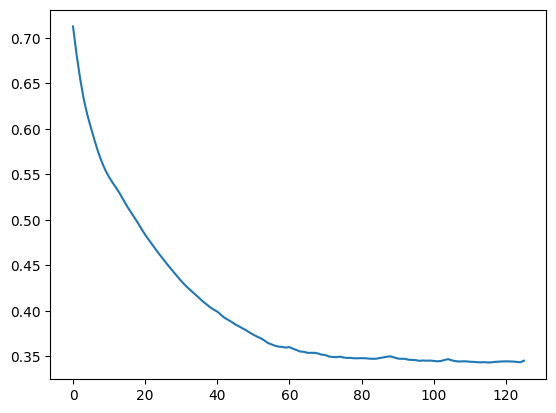

In [43]:
plt.plot(history['val_loss'])

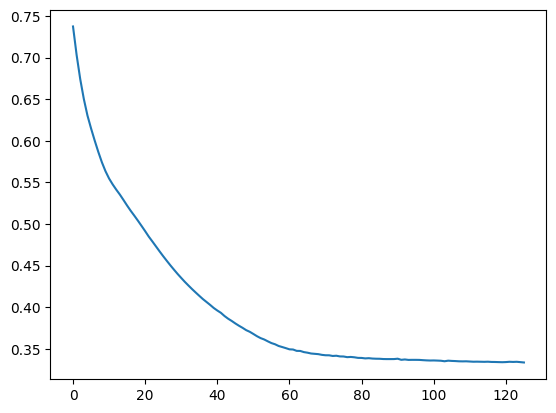

In [44]:
plt.plot(history['loss'])

#### Evaluate Model

In [45]:
y_pred = deep_model.predict(x_test)
y_pred = y_pred.round()

32/32 [==============================] - 0s 580us/step


In [46]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

(
    accuracy_score(y_test, y_pred),
    precision_score(y_test, y_pred),
    recall_score(y_test, y_pred),
    f1_score(y_test, y_pred),
    roc_auc_score(y_test, y_pred),
)

(0.8259149357072205,
 0.6889952153110048,
 0.5647058823529412,
 0.6206896551724138,
 0.7393635231870527)

In [47]:
pd.Series(y_pred.reshape(-1)).value_counts()

0.0    802
1.0    209
Name: count, dtype: int64

## 4. Final Model

In [48]:
import xgboost as xgb
from sklearn.metrics import f1_score

params = {'alpha': 0.0023405959069878147,
 'colsample_bytree': 0.9922414848515086,
 'custom_metric': None,
 'early_stopping_rounds': 50,
 'eval_metric': 'auc',
 'gamma': 0.0001556165502184308,
 'lambda': 12.26727735578625,
 'learning_rate': 0.03635030340361273,
 'max_depth': 99,
 'maximize': None,
 'min_child_weight': 0.1493103731370199,
 'num_boost_round': 5000,
 'objective': 'binary:logistic',
 'scale_pos_weight': 30.265488423226277,
 'seed': 123,
 'subsample': 0.9548053368066984,
 'verbose_eval': False,
 'enable_categorical': True,
 'tree_method': 'hist'}

# params = {'alpha': 0.005584013947653967,
#  'colsample_bytree': 0.767872589594243,
#  'gamma': 0.011320203235405252,
#  'lambda': 6.244709782669356,
#  'learning_rate': 1.0052846269486904,
#  'max_depth': 41,
#  'min_child_weight': 4.7903550386199765,
#  'scale_pos_weight': 39.37939616204363,
#  'subsample': 0.9980654615049733,
#  'enable_categorical': True,
#  'tree_method': 'hist',
#  'eval_metric': 'auc',
#  'early_stopping_rounds': 10}
evaluation = [( X_train, y_train), ( X_val, y_val)]
xgb_model = xgb.XGBClassifier(**params)
xgb_model.fit(X_train, y_train, eval_set=evaluation)
y_pred = xgb_model.predict(X_test)

[0]	validation_0-auc:0.67288	validation_1-auc:0.46579
[1]	validation_0-auc:0.81705	validation_1-auc:0.49582
[2]	validation_0-auc:0.84903	validation_1-auc:0.51871
[3]	validation_0-auc:0.86971	validation_1-auc:0.53870
[4]	validation_0-auc:0.88470	validation_1-auc:0.53284
[5]	validation_0-auc:0.89272	validation_1-auc:0.52595
[6]	validation_0-auc:0.90034	validation_1-auc:0.53034
[7]	validation_0-auc:0.91047	validation_1-auc:0.53271
[8]	validation_0-auc:0.91687	validation_1-auc:0.52835
[9]	validation_0-auc:0.92379	validation_1-auc:0.53020
[10]	validation_0-auc:0.92167	validation_1-auc:0.53481
[11]	validation_0-auc:0.92717	validation_1-auc:0.53661
[12]	validation_0-auc:0.92998	validation_1-auc:0.54035
[13]	validation_0-auc:0.93532	validation_1-auc:0.53587
[14]	validation_0-auc:0.93547	validation_1-auc:0.53813
[15]	validation_0-auc:0.94036	validation_1-auc:0.53388
[16]	validation_0-auc:0.94441	validation_1-auc:0.53242
[17]	validation_0-auc:0.94617	validation_1-auc:0.53166
[18]	validation_0-au

In [49]:
y_pred

array([1, 1, 1, ..., 1, 1, 1])

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

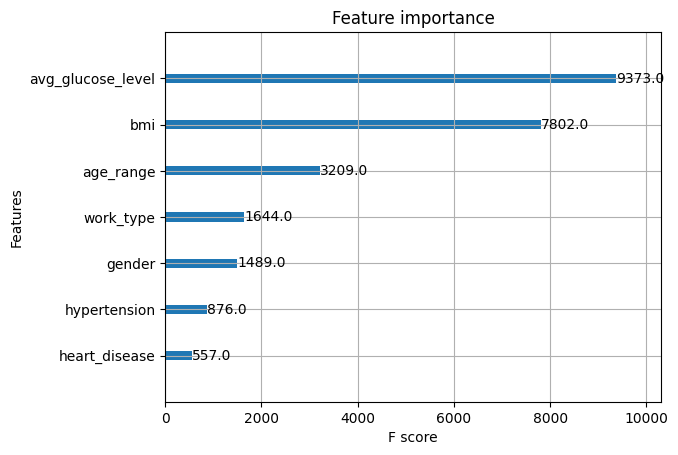

In [50]:
xgb.plot_importance(xgb_model)

In [51]:
xgb_model.save_model('xgb_model.json')

## 5. Use model.py to predict test

In [52]:
from predict import *
model = load_model('xgb_model.json')
test_data, ground_truth_label = read_data_csv()
prediction_output, report_metrics = run_prediction(model, test_data, ground_truth_label)

In [53]:
prediction_output

array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)

In [54]:
report_metrics

{'accuracy': 0.2534124629080119,
 'precision': 0.22952853598014888,
 'recall': 0.9585492227979274,
 'f1_score': 0.3703703703703704,
 'roc_auc': 0.5012145652095873}

In [55]:
pd.Series(prediction_output).value_counts()

1.0    4836
0.0     219
Name: count, dtype: int64